### Install from command line

```bash
sudo apt-get install r-bioc-biocgenerics
```

### Install CRAN packages

```R
install.packages('devtools')
install.packages('tidyverse')
```

### Install GitHub pakcages

```R
devtools::install_github("wesm/feather/R")
```

### Install BioConductor packages

```
source("https://bioconductor.org/biocLite.R")
biocLite("cytofkit")
biocLite("flowCore")
biocLite("flowiz")
biocLite("flowMeans")
```

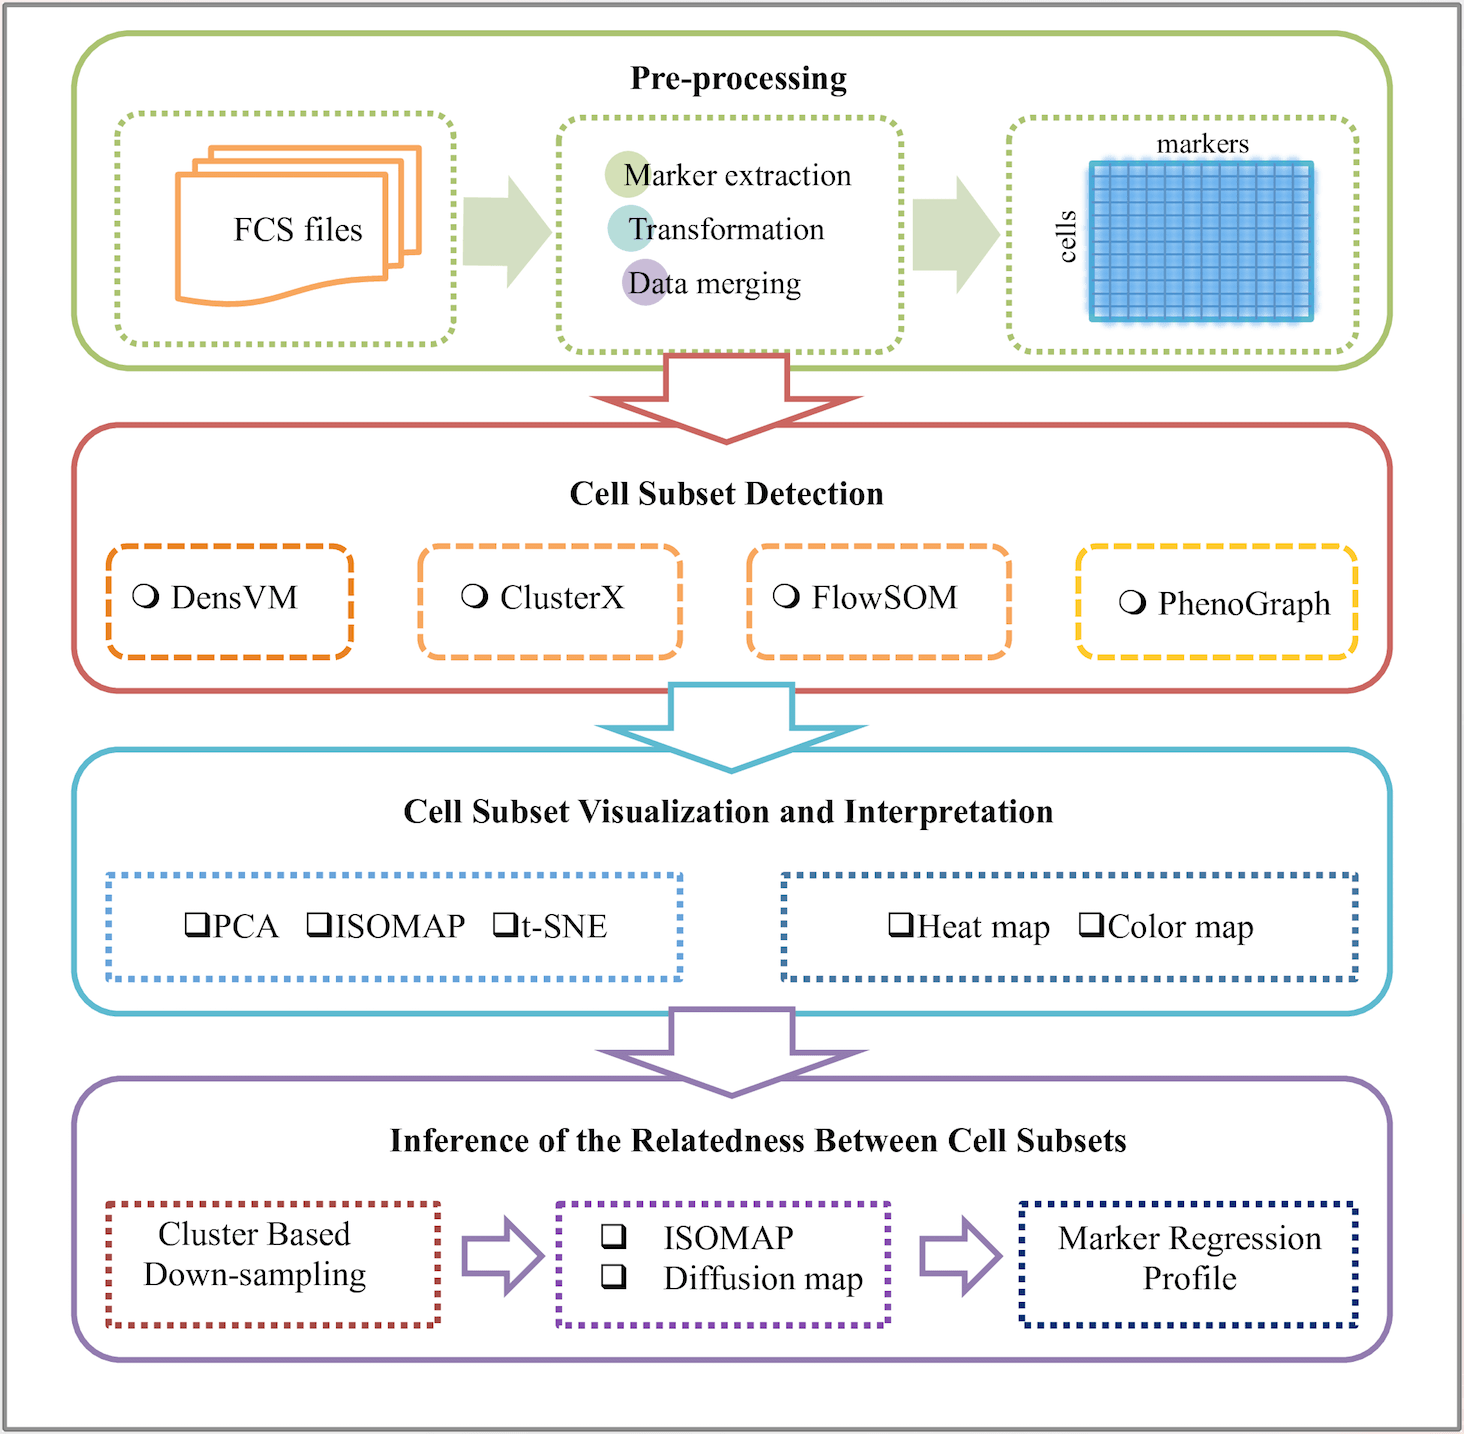

In [1]:
library(tidyverse)
library(cytofkit)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:purrr’:

    compact

Warning mess

In [2]:
## Loading the FCS data:  

set.seed(100)
files <- list.files('data' , pattern='AMJ_5L.*.fcs', full=TRUE)

In [3]:
files

[1] "data/AMJ_5L_CMV pp65.fcs" "data/AMJ_5L_Costim.fcs"  
[3] "data/AMJ_5L_SEB.fcs"

In [4]:
## Extract the expression matrix with transformation

data_transformed <- cytof_exprsMerge(
    fcsFiles = files, 
    comp=FALSE,
    transformMethod = "cytofAsinh",
    mergeMethod = "all"
)

In [9]:
help(cytof_exprsMerge)

In [5]:
head(data_transformed[ ,1:3], 3)

,FSC-A<NA>,FSC-H<NA>,FSC-W<NA>
AMJ_5L_CMV pp65_1,4.395957,1.05434364,1.268509
AMJ_5L_CMV pp65_2,4.419930,1.57086905,1.381216
AMJ_5L_CMV pp65_3,4.360044,0.04676215,1.273687


In [6]:
tail(data_transformed[ ,1:3], 3)

,FSC-A<NA>,FSC-H<NA>,FSC-W<NA>
AMJ_5L_SEB_422656,3.095722,2.652748,0.8216736
AMJ_5L_SEB_422657,1.835174,1.491520,0.8638089
AMJ_5L_SEB_422658,3.150749,2.806495,0.7667107


In [7]:
# subsample data to complete before universe collapses
n <- 1000
data_transformed <- as.data.frame(data_transformed) %>% 
sample_n(n, replace = FALSE)

In [8]:
## use clustering algorithm to detect cell subsets

## run PhenoGraph
cluster_PhenoGraph <- cytof_cluster(
    xdata = data_transformed, 
    method = "Rphenograph"
)

  Running PhenoGraph...

Run Rphenograph starts:
  -Input data of 1000 rows and 17 columns
  -k is set to 30


  Finding nearest neighbors...DONE ~ 0.069 s
  Compute jaccard coefficient between nearest-neighbor sets...DONE ~ 0.228 s
  Build undirected graph from the weighted links...DONE ~ 0.094 s
  Run louvain clustering on the graph ...DONE ~ 0.049 s


Run Rphenograph DONE, took a total of 0.440000000000003s.


  Return a community class
  -Modularity value: 0.8429702 
  -Number of clusters: 11 DONE!


In [9]:
## reduce dimensionality with t-sne

data_transformed_tsne <- cytof_dimReduction(
    data=data_transformed, 
    method = "tsne"
)

  Running t-SNE...with seed 42  DONE


In [10]:
## run ClusterX

cluster_ClusterX <- cytof_cluster(
    ydata = data_transformed_tsne, 
    method="ClusterX"
)

  Running ClusterX...    Calculate cutoff distance...2.46  
    Calculate local Density...DONE!
    Detect nearest neighbour with higher density...DONE!
    Peak detection...DONE!
    Cluster assigning...DONE!
 DONE!


In [11]:
## run Cluster_DenseVM

cluster_DensVM <- cytof_cluster(
    xdata = data_transformed, 
    ydata = data_transformed_tsne, 
    method = "DensVM"
)

  Running DensVM...Testing kernel bandwidth for  20 points in the range min= 0.5091842  to max= 5.091842 
This will take a while...
Computing number of peaks for kernel bandwidth =  0.5091842 
Computing number of peaks for kernel bandwidth =  0.7503768 
Computing number of peaks for kernel bandwidth =  0.9915693 
Computing number of peaks for kernel bandwidth =  1.232762 
Computing number of peaks for kernel bandwidth =  1.473954 
Computing number of peaks for kernel bandwidth =  1.715147 
Computing number of peaks for kernel bandwidth =  1.956339 
Computing number of peaks for kernel bandwidth =  2.197532 
Computing number of peaks for kernel bandwidth =  2.438724 
Computing number of peaks for kernel bandwidth =  2.679917 
Computing number of peaks for kernel bandwidth =  2.92111 
Computing number of peaks for kernel bandwidth =  3.162302 
Computing number of peaks for kernel bandwidth =  3.403495 
Computing number of peaks for kernel bandwidth =  3.644687 
Computing number of peaks 

In [12]:
## run FlowSOM with cluster number 25

cluster_FlowSOM <- cytof_cluster(
    xdata = data_transformed,
    method = "FlowSOM", 
    FlowSOM_k = 25
)

  Running FlowSOM...    Building SOM...
    Meta clustering to 25 clusters...
 DONE!


In [13]:
## combine data

data_all <- cbind(
    data_transformed, 
    data_transformed_tsne, 
    PhenoGraph = cluster_PhenoGraph,
    ClusterX=cluster_ClusterX, 
    ClusterDensVM=cluster_DensVM,
    FlowSOM=cluster_FlowSOM
)
data_all <- as.data.frame(data_all)

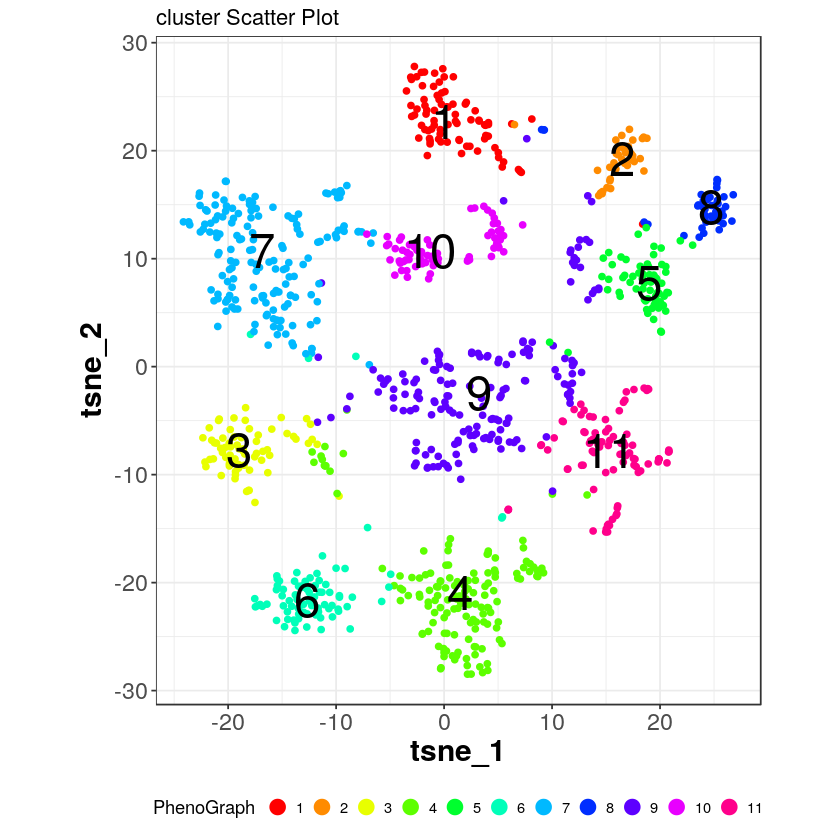

In [14]:
## PhenoGraph plot on tsne

cytof_clusterPlot(
    data=data_all, 
    xlab="tsne_1", 
    ylab="tsne_2", 
    cluster="PhenoGraph", 
    sampleLabel = FALSE)

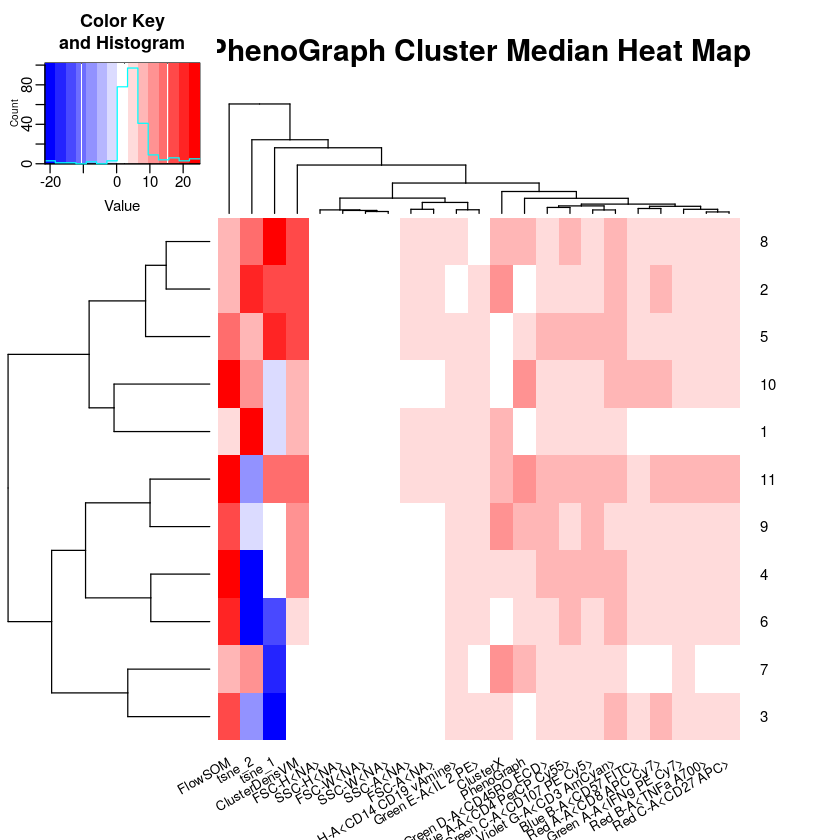

In [15]:
## PhenoGraph cluster heatmap

PhenoGraph_cluster_median <- aggregate(. ~ PhenoGraph, 
                                       data = data_all, median)
cytof_heatmap(PhenoGraph_cluster_median, 
              baseName = "PhenoGraph Cluster Median")

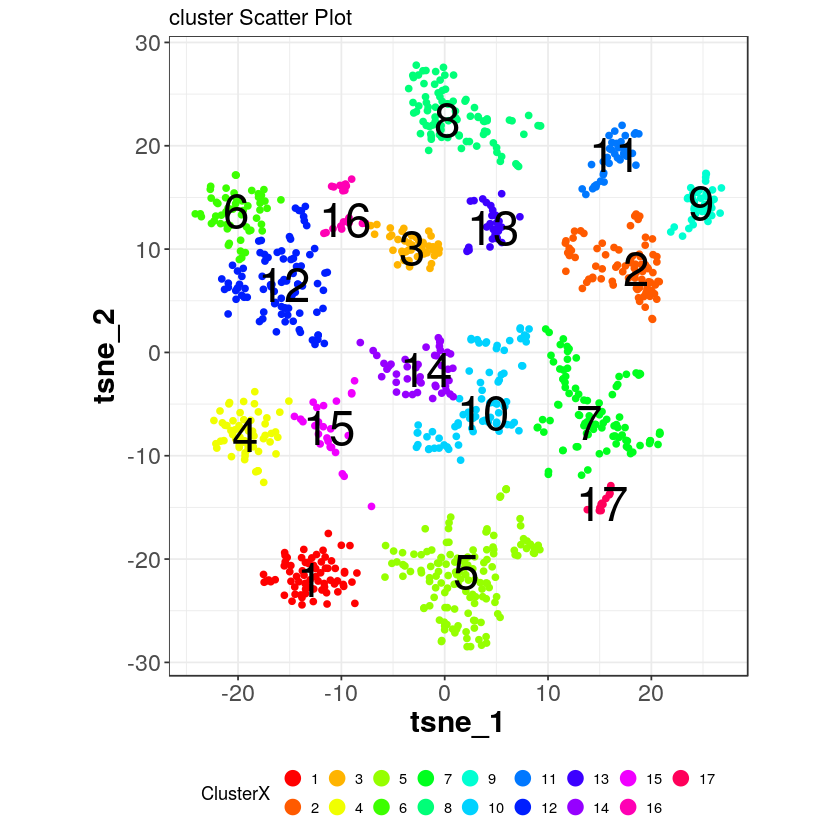

In [16]:
## ClusterX plot on tsne

cytof_clusterPlot(
    data=data_all,
    xlab="tsne_1", 
    ylab="tsne_2", 
    cluster="ClusterX",
    sampleLabel = FALSE
)

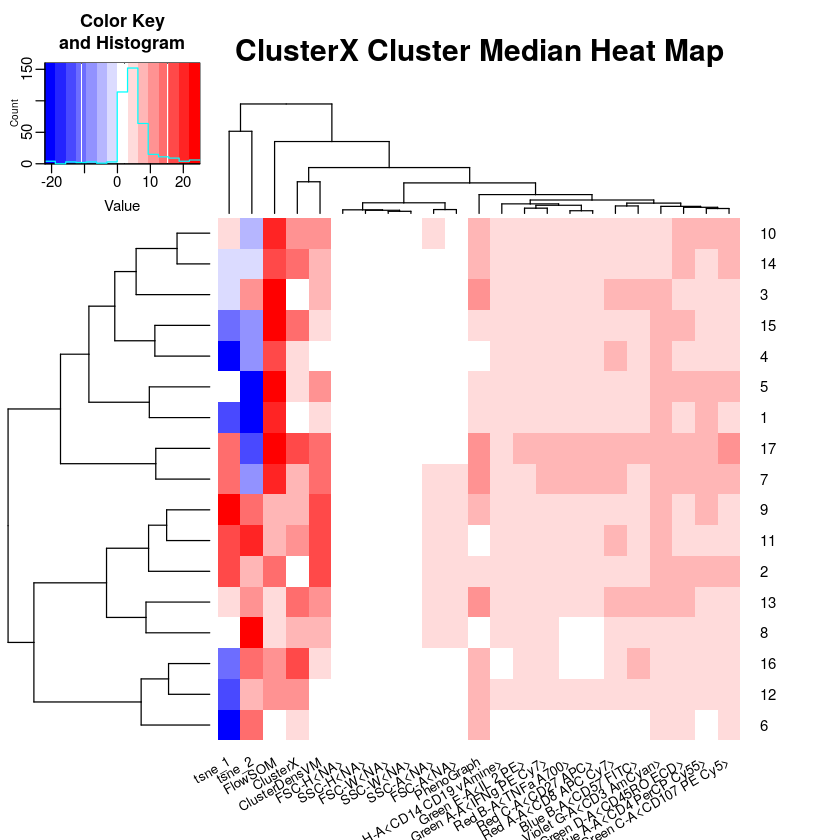

In [17]:
## ClusterX cluster heatmap

ClusterX_cluster_median <- aggregate(. ~ ClusterX, 
                                     data = data_all, median)
cytof_heatmap(ClusterX_cluster_median, 
              baseName = "ClusterX Cluster Median")

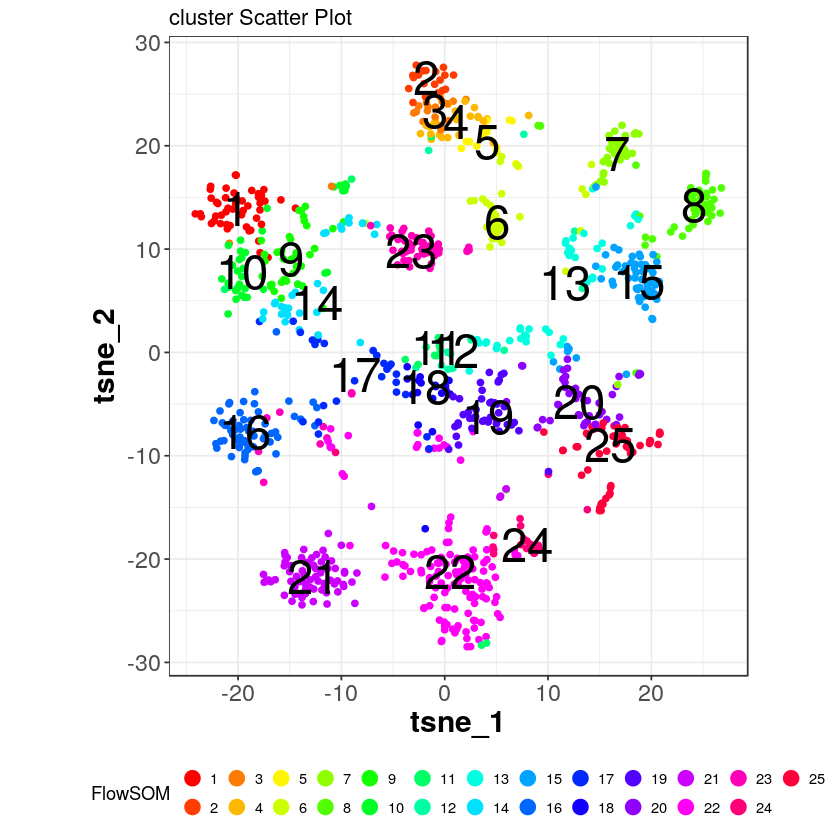

In [18]:
## FlowSOM plot on tsne

cytof_clusterPlot(
    data=data_all, 
    xlab="tsne_1", 
    ylab="tsne_2", 
    cluster="FlowSOM", 
    sampleLabel = FALSE
)

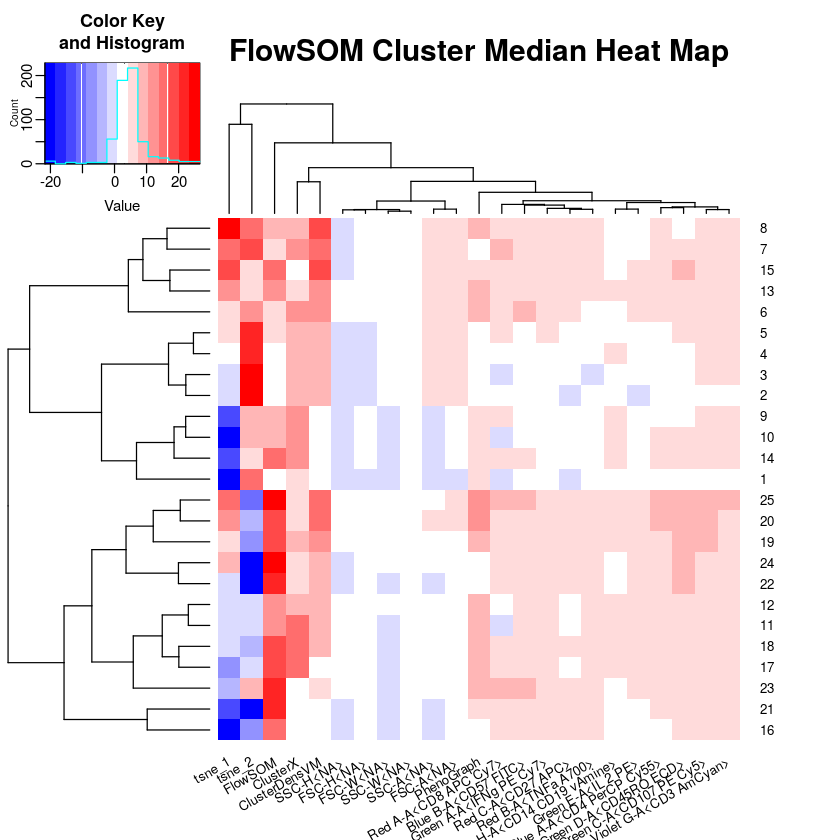

In [19]:
## FlowSOM cluster heatmap

FlowSOM_cluster_median <- aggregate(. ~ FlowSOM, 
                                    data = data_all,
                                    median)
cytof_heatmap(
    FlowSOM_cluster_median, 
    baseName = "FlowSOM Cluster Median")

In [20]:
## Inference of PhenoGraph cluster relatedness

PhenoGraph_progression <- cytof_progression(
    data = data_transformed, 
    cluster = cluster_PhenoGraph, 
    method="isomap", 
    clusterSampleSize = 50, 
    sampleSeed = 5
)

  Running ISOMAP...  DONE


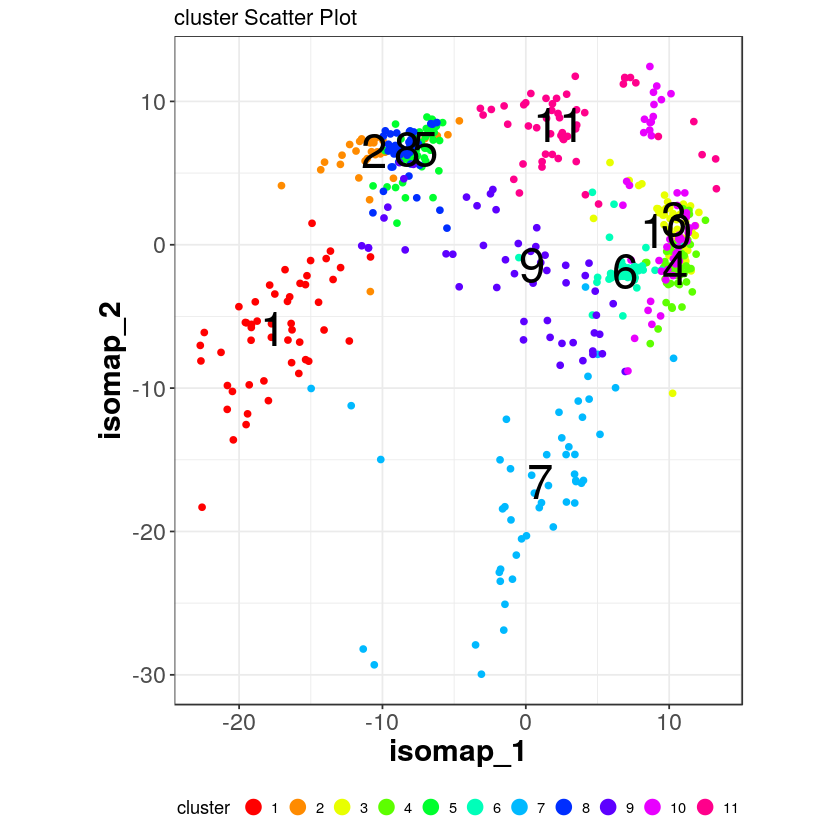

In [21]:
p_d <- data.frame(PhenoGraph_progression$sampleData, 
                  PhenoGraph_progression$progressionData, 
                  cluster = PhenoGraph_progression$sampleCluster, 
                  check.names = FALSE)

## cluster relatedness plot
cytof_clusterPlot(
    data=p_d, 
    xlab="isomap_1", 
    ylab="isomap_2", 
    cluster="cluster", 
    sampleLabel = FALSE
)

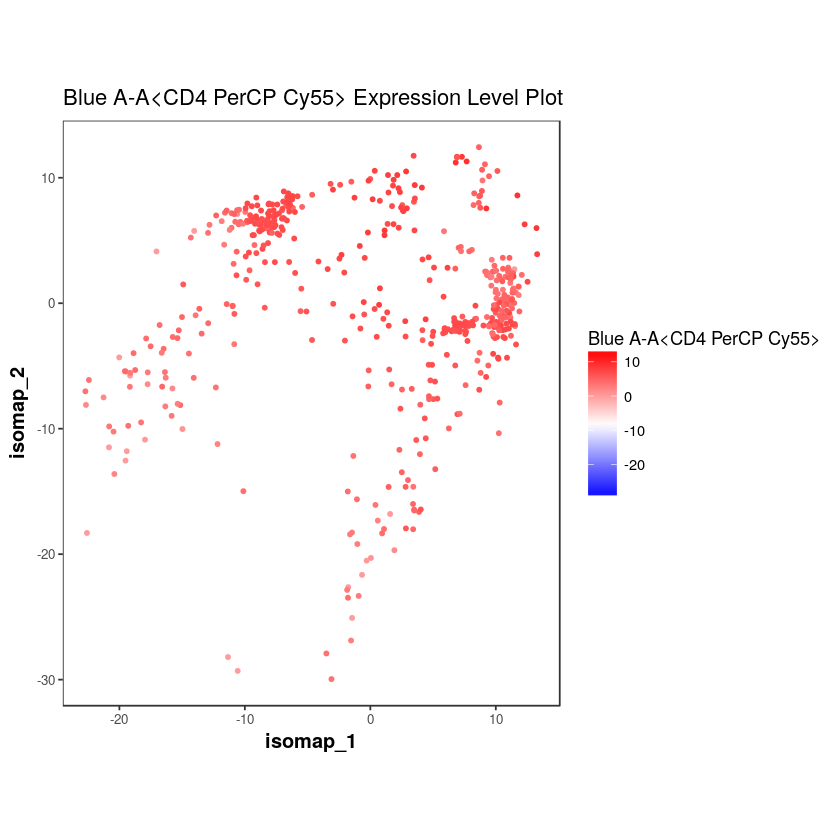

In [22]:
## marker expression profile
markers <- c("Blue A-A<CD4 PerCP Cy55>", 
             "Red A-A<CD8 APC Cy7>")

cytof_colorPlot(data=p_d, 
                xlab="isomap_1", 
                ylab="isomap_2", 
                zlab = markers[1], 
                limits = range(p_d))

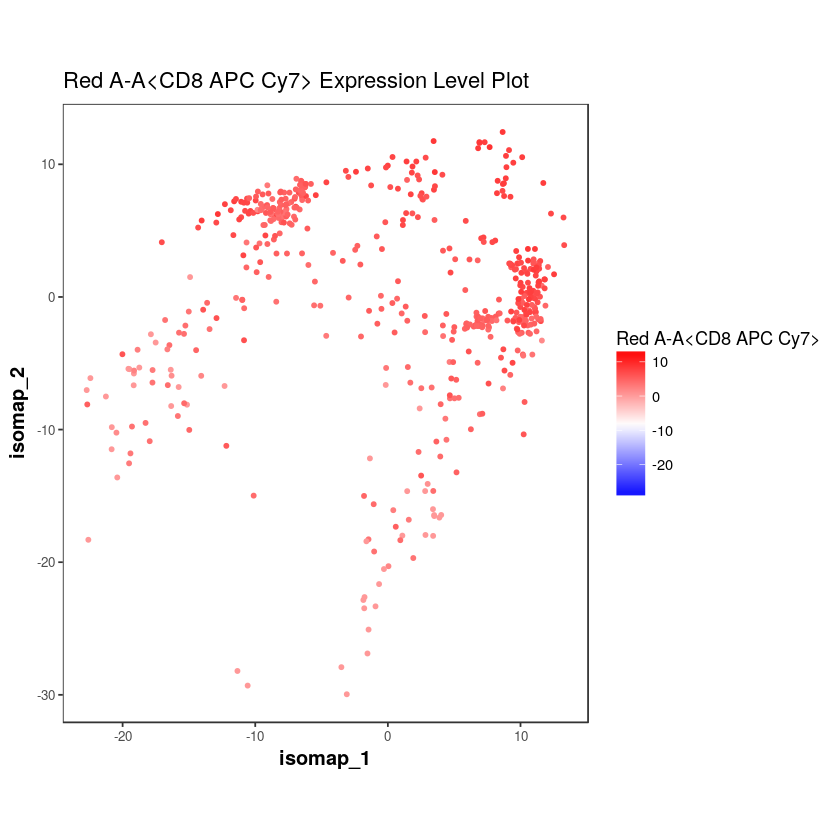

In [23]:
cytof_colorPlot(
    data=p_d, 
    xlab="isomap_1", 
    ylab="isomap_2", 
    zlab = markers[2], 
    limits = range(p_d)
)

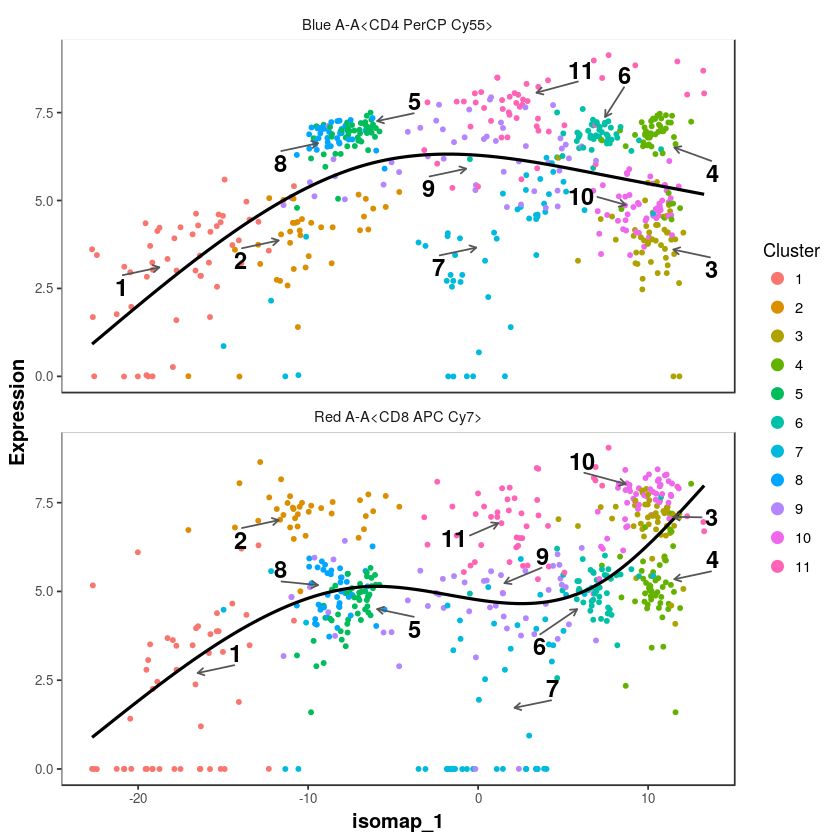

In [24]:
cytof_progressionPlot(
    data=p_d, 
    markers=markers, 
    orderCol="isomap_1",
    clusterCol = "cluster"
)

In [25]:
## Inference of ClusterX cluster relatedness
ClusterX_progression <- cytof_progression(
    data = data_transformed, 
    cluster = cluster_ClusterX, 
    method="isomap", 
    clusterSampleSize = 30, 
    sampleSeed = 3
)

  Running ISOMAP...  DONE


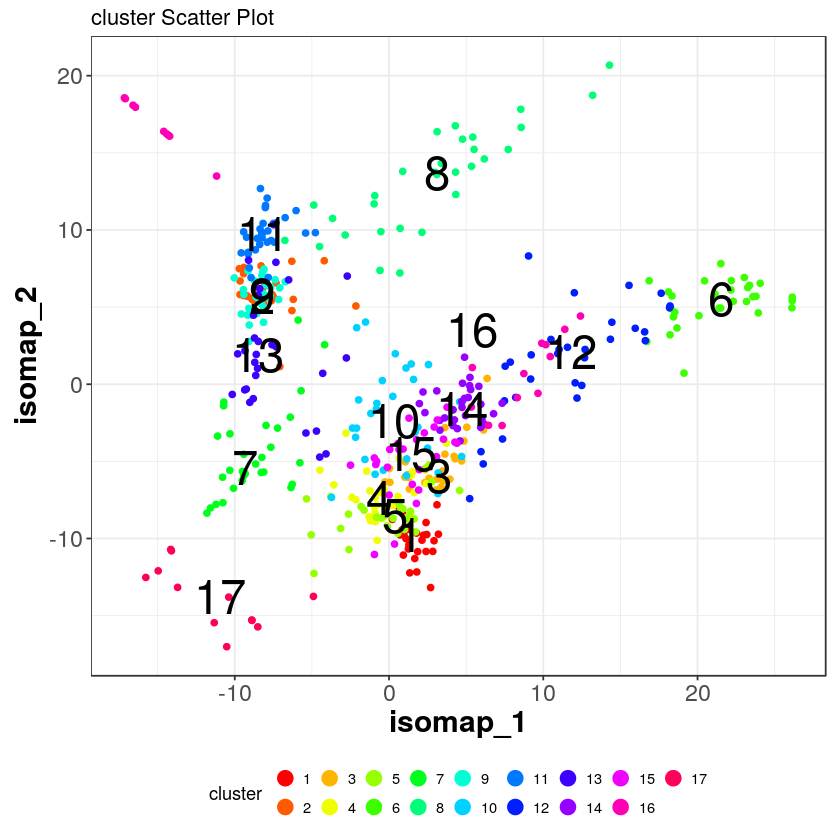

In [26]:
c_d <- data.frame(ClusterX_progression$sampleData, 
                  ClusterX_progression$progressionData,
                  cluster=ClusterX_progression$sampleCluster, 
                  check.names = FALSE)

## cluster relatedness plot
cytof_clusterPlot(
    data=c_d, 
    xlab="isomap_1", 
    ylab="isomap_2", 
    cluster="cluster", 
    sampleLabel = FALSE
)

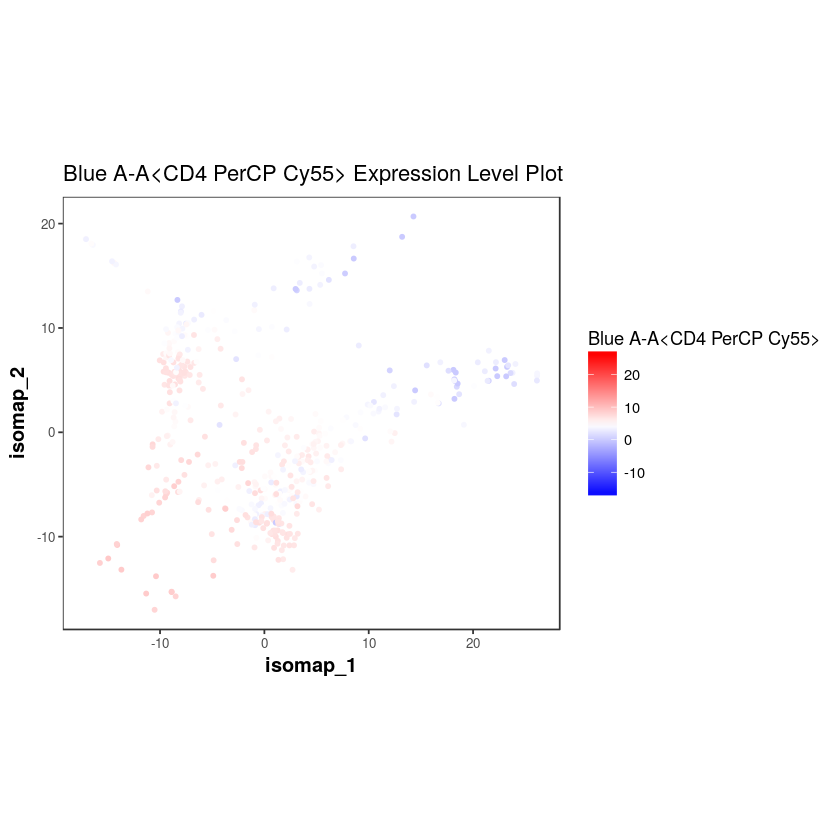

In [27]:
## marker expression profile
cytof_colorPlot(data=c_d,
                xlab="isomap_1", 
                ylab="isomap_2", 
                zlab = markers[1], 
                limits = range(c_d))

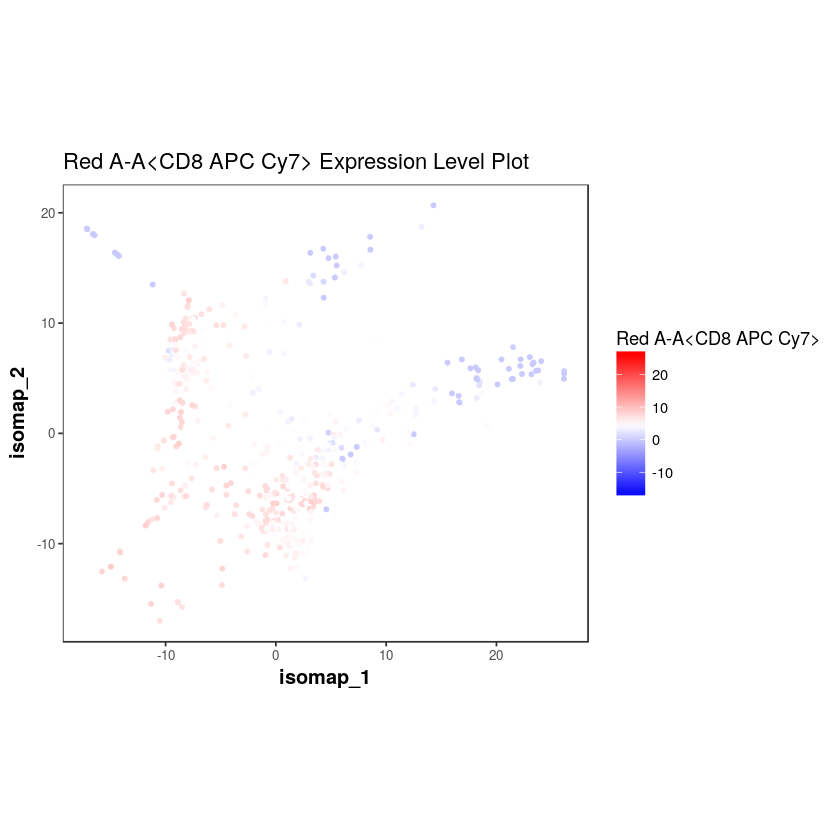

In [28]:
cytof_colorPlot(
    data=c_d, 
    xlab="isomap_1", 
    ylab="isomap_2", 
    zlab = markers[2], 
    limits = range(c_d)
)

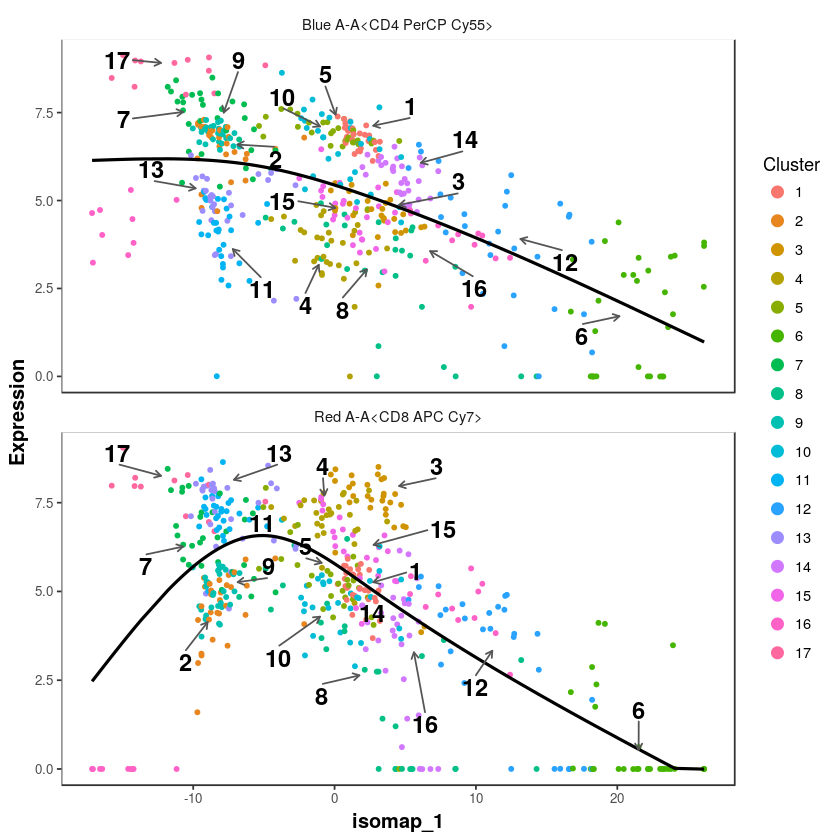

In [29]:
cytof_progressionPlot(
    data=c_d, 
    markers, 
    orderCol="isomap_1", 
    clusterCol = "cluster"
)

In [30]:
## save analysis results to FCS file
cytof_addToFCS(
    data_all, 
    rawFCSdir='data',
    analyzedFCSdir="analysed_FCS", 
    transformed_cols = c("tsne_1", "tsne_2"), 
    cluster_cols = c("PhenoGraph",
                     "ClusterX", 
                     "ClusterDensVM",
                     "FlowSOM")
)

Save to file: data/AMJ_5L_CMV pp65.fcs 
Save to file: data/AMJ_5L_SEB.fcs 
Save to file: data/AMJ_5L_Costim.fcs 
